# 東京エレクトロン株価（日足）

In [1]:
import sys
sys.path.append('..')

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [2]:
symbol = '8035.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-05 00:00:00+09:00,22318.022688,22723.804919,21882.549075,22194.308594,5567800,0.0,0.0
2024-09-06 00:00:00+09:00,22382.353006,22560.501294,21585.634272,21773.679688,4987000,0.0,0.0
2024-09-09 00:00:00+09:00,20289.111464,21278.824219,20239.625827,21278.824219,6414600,0.0,0.0
2024-09-10 00:00:00+09:00,21773.680544,22238.845537,20922.527577,22031.005859,7054300,0.0,0.0
2024-09-11 00:00:00+09:00,22001.313786,22565.450037,21481.714607,21981.519531,7219700,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-27 00:00:00+09:00,23350.000000,23395.000000,22970.000000,23155.000000,3757500,0.0,0.0
2025-02-28 00:00:00+09:00,22300.000000,22465.000000,21785.000000,22125.000000,5111500,0.0,0.0
2025-03-03 00:00:00+09:00,22465.000000,22515.000000,22075.000000,22380.000000,2698700,0.0,0.0


## 日足チャートとパラボリック SAR

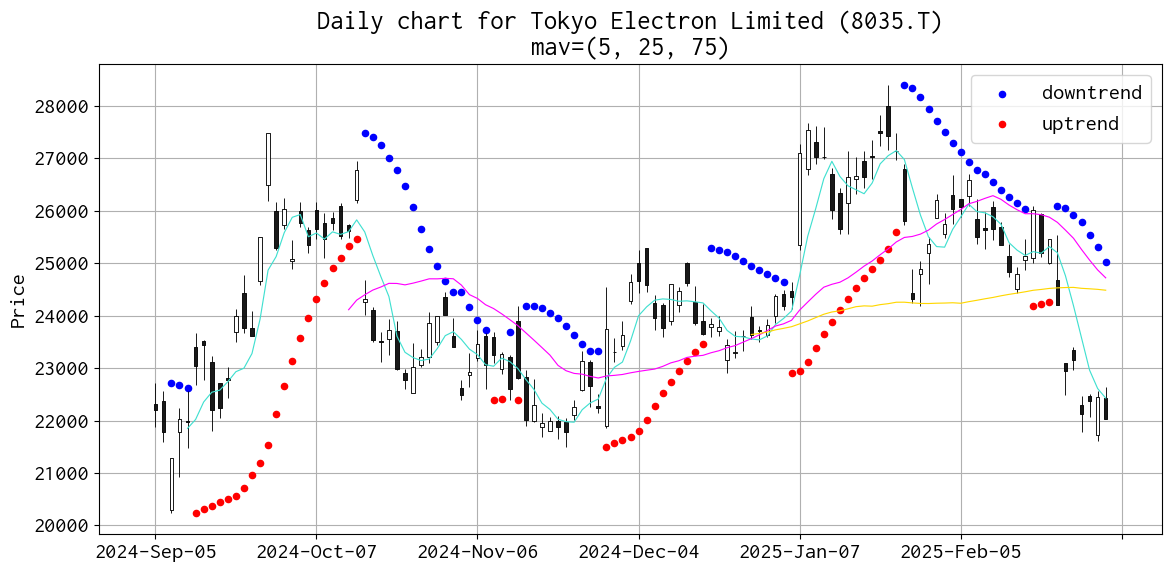

In [3]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_8035.png')
plt.show()

In [7]:
df.tail(2)['Close']

Date
2025-03-04 00:00:00+09:00    22450.0
2025-03-05 00:00:00+09:00    22450.0
Name: Close, dtype: float64

In [8]:
df.tail(2)['Close'].diff()

Date
2025-03-04 00:00:00+09:00    NaN
2025-03-05 00:00:00+09:00    0.0
Name: Close, dtype: float64

# Tokyo Electron Limited (ADR)

In [10]:
symbol1 = 'TOELY'
ticker1 = yf.Ticker(symbol1)

df1 = ticker1.history(period='6mo')
df1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-05 00:00:00-04:00,78.389999,79.959999,78.160004,79.449997,138100,0.0,0.0
2024-09-06 00:00:00-04:00,76.209999,77.989998,73.110001,73.639999,138300,0.0,0.0
2024-09-09 00:00:00-04:00,74.690002,75.540001,73.889999,75.180000,247300,0.0,0.0
2024-09-10 00:00:00-04:00,78.680000,79.989998,76.610001,78.500000,282200,0.0,0.0
2024-09-11 00:00:00-04:00,79.980003,82.029999,78.360001,82.000000,242100,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-26 00:00:00-05:00,77.989998,78.160004,76.519997,77.320000,107200,0.0,0.0
2025-02-27 00:00:00-05:00,76.800003,77.250000,75.169998,75.190002,81900,0.0,0.0
2025-02-28 00:00:00-05:00,74.349998,74.830002,72.879997,74.330002,116100,0.0,0.0


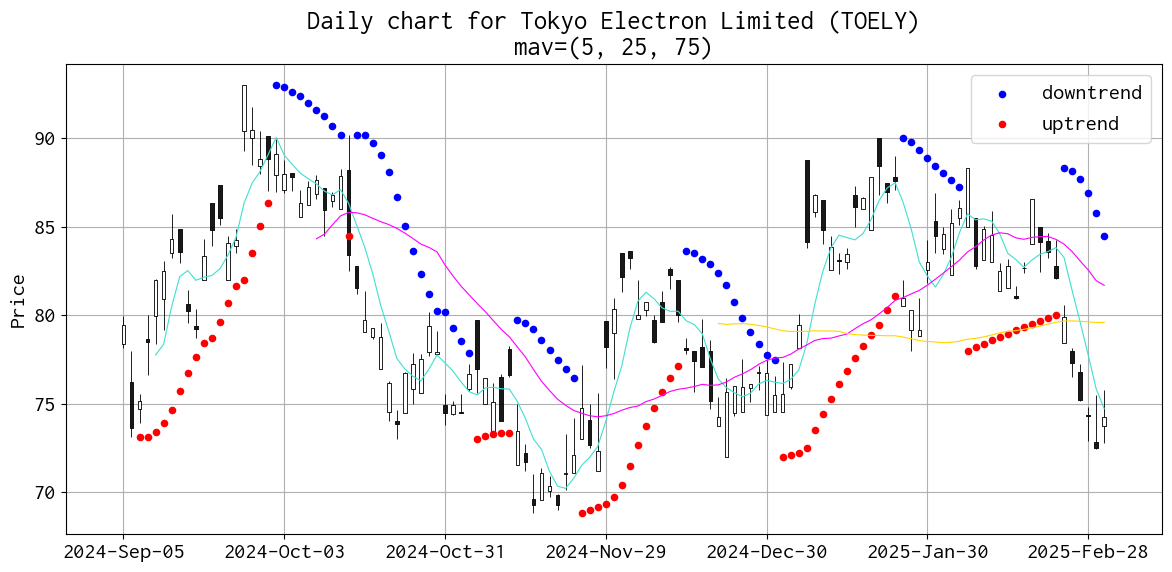

In [11]:
dict_psar = psar(df1)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df1,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker1.info['longName'], symbol1))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol1)

ax.grid()

plt.tight_layout()
plt.savefig('report_daily_chart_TOELY.png')
plt.show()